3 Trace(s) in Stream:
XB.ELYSE.02.BHU | 2019-06-14T12:19:44.897000Z - 2019-06-14T12:27:20.197000Z | 20.0 Hz, 9107 samples
XB.ELYSE.02.BHV | 2019-06-14T12:19:43.747000Z - 2019-06-14T12:27:13.397000Z | 20.0 Hz, 8994 samples
XB.ELYSE.02.BHW | 2019-06-14T12:19:56.147000Z - 2019-06-14T12:27:05.297000Z | 20.0 Hz, 8584 samples
3 Trace(s) in Stream:
XB.ELYSE.02.BHU | 2019-06-14T12:19:56.147000Z - 2019-06-14T12:27:05.297000Z | 20.0 Hz, 8584 samples
XB.ELYSE.02.BHV | 2019-06-14T12:19:56.147000Z - 2019-06-14T12:27:05.297000Z | 20.0 Hz, 8584 samples
XB.ELYSE.02.BHW | 2019-06-14T12:19:56.147000Z - 2019-06-14T12:27:05.297000Z | 20.0 Hz, 8584 samples
Files are 8584 datapoints long
1/8327 windows processed
1001/8327 windows processed
2001/8327 windows processed
3001/8327 windows processed
4001/8327 windows processed
5001/8327 windows processed
6001/8327 windows processed
7001/8327 windows processed
8001/8327 windows processed


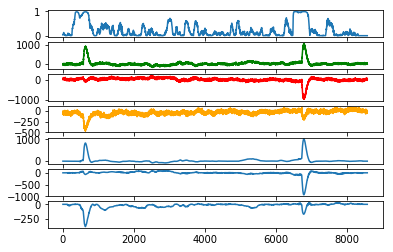

In [9]:
from obspy import UTCDateTime
from obspy import read
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
import sys
from obspy.signal.trigger import plot_trigger
from obspy.signal.trigger import classic_sta_lta
from obspy.signal.trigger import trigger_onset


# Read in the three components from file into a stream
st = read("XB.02.ELYSE.BH?-2019.165T1219-2019.165T1227")

# Print representation of streams
print(st)

# Check for same start time and cut if necessary
cutt = np.max([trace.stats.starttime for trace in st])
endt = np.min([trace.stats.endtime for trace in st])
st.trim(cutt,endt)
st.detrend()

# Print trimmed representation of streams
print(st)

#check for number of samples - needs to be the same
assert len(st) == 3, 'There must be three traces in the stream'
assert st[0].stats.npts == st[1].stats.npts, 'Trace 0 and 1 different lengths'
assert st[1].stats.npts == st[2].stats.npts, 'Trace 1 and 2 different lengths'
print('Files are {0} datapoints long'.format(st[0].stats.npts))

#set up N and file length variables
n_traces = 3
N=256  # length of window
n_f = 7  # number of frequencies, must be an odd number

g = 4
npts = st[0].stats.npts
outst = np.zeros((n_traces,npts))
#print(N)

#set up arrays
data = np.array([st[p].data for p in range(n_traces)])
ptemp = np.zeros((n_traces,N), dtype='complex')

Pg = np.zeros(npts)

n_windows = npts-N-1

#Set up while loop for the time windows and create temp arrays
for l in range(n_windows):
    if l%1000 == 0:
        print('{0}/{1} windows processed'.format(l+1, n_windows))

    # Take the fourier transform of the data window
    fft_temp = np.fft.fft(data[:,l:l+N])
    
    # Compute the conjugate values
    conj_fft_temp = np.conj(fft_temp)

    # The following lines of code set up the sliding frequency window
    # and form the spectral matrix S - or in this case, sumS since S
    # is generated for the n_f frequencies in the window.
    fn = np.einsum('ik, jk -> jik', fft_temp, conj_fft_temp)

    sumS = np.array([np.sum(fn[:,:,a:(a+n_f)], axis=2)
                     for a in range(N-n_f+1)])

    trS = np.real(np.einsum('ijj -> i', sumS)) # trace of each sum
    trS2 = np.real(np.einsum('ijk, ikj -> i', sumS, sumS)) # sumS[j,k]*sumS[k,j]

    P = (3.*trS2 - (trS**2))/(2.*(trS**2))

    #  Attempt to add in filtering of data
    halfnf = int((n_f-1.)/2.)
    ptemp[:,:halfnf] = fft_temp[:,:halfnf] * (P[0]**g)
    ptemp[:,halfnf:N-halfnf] = fft_temp[:,halfnf:N-halfnf] * (P**g)
    ptemp[:,N-halfnf:N] = fft_temp[:,N-halfnf:N] * (P[-1]**g)

    ifft_ptemp = np.fft.ifft(ptemp)

    Pg[l] = P[2]**g

    halfN = int(N/2.)
    outst[:,l+halfN-1] = np.real(ifft_ptemp[:,halfN])

fig, axes = plt.subplots(7,1,sharex='all')
axes[0].plot(Pg)
axes[1].plot(st[0].data,color='green')
axes[2].plot(st[1].data,color='red')
axes[3].plot(st[2].data,color='orange')
axes[4].plot(outst[0])
axes[5].plot(outst[1])
axes[6].plot(outst[2])

fig.savefig('output.pdf')

#Save Pg for future reference
np.savetxt('pgout',Pg)

#Triggering algorithm to extract glitch times (may need refining)
trig = trigger_onset(Pg, 0.9, 0.75, 460)

times = trig.ravel()
tout = []

l = len(times)
for i in range (l):
    tout.append(cutt + (int(times[i])*(st[0].stats.delta)))
   

In [6]:
from obspy.signal.trigger import trigger_onset

trig = np.array(trigger_onset(Pg, 0.9, 0.75, 200))
print(trig)
#print(len(trig))
l = len(trig)
times = np.zeros((l,2))
for i in range (len(trig)):
    for j in range (2):
        times[i,j] = cutt + (trig[i,j]*st[0].stats.delta)
print(times)


[[ 340  540]
 [ 541  741]
 [6499 6699]
 [6907 6935]]
[[  1.56051481e+09   1.56051482e+09]
 [  1.56051482e+09   1.56051483e+09]
 [  1.56051512e+09   1.56051513e+09]
 [  1.56051514e+09   1.56051514e+09]]


In [7]:
trig = trigger_onset(Pg, 0.9, 0.75, 500)
times = trig.ravel()

l = len(times)
for i in range (l):
    print(cutt + (int(times[i]))*(st[0].stats.delta))   

2019-06-14T12:20:13.147000Z
2019-06-14T12:20:33.597000Z
2019-06-14T12:25:21.097000Z
2019-06-14T12:25:42.897000Z


In [5]:
#This works for writing out channels. Stats here are for BHU.
from obspy import UTCDateTime, read, Trace, Stream
stats = {'network' : 'XB', 'station' : 'ELYSE',
        'location' : '02', 'channel' : 'BHU',
        'npts' : len(outst[0].data), 'sampling_rate' :20,
        'starttime':cutt, 'mseed':{'dataquality':'D'}}
         
st1 = Stream([Trace(data=outst[0], header=stats)])
st1.write("ufilt.mseed", format='MSEED')


In [6]:
print(tout)



[UTCDateTime(2019, 6, 14, 12, 20, 13, 147000), UTCDateTime(2019, 6, 14, 12, 20, 33, 597000), UTCDateTime(2019, 6, 14, 12, 25, 21, 97000), UTCDateTime(2019, 6, 14, 12, 25, 42, 897000)]


In [7]:
print(ifft_ptemp)


[[ 13.63700532 -2.25974882e+00j  12.96418526 -2.24676185e+00j
   14.75986750 -2.22849953e+00j  13.48002291 -2.20497388e+00j
   14.86489464 -2.17621745e+00j  13.55313943 -2.14228326e+00j
   14.67899419 -2.10324446e+00j  13.42707521 -2.05919407e+00j
   14.34153238 -2.01024446e+00j  13.39588326 -1.95652690e+00j
   13.91808285 -1.89819088e+00j  13.65843966 -1.83540345e+00j
   14.01475289 -1.76834839e+00j  14.46420378 -1.69722542e+00j
   14.92282305 -1.62224921e+00j  15.56517606 -1.54364838e+00j
   15.71753003 -1.46166448e+00j  16.45953378 -1.37655083e+00j
   16.06997388 -1.28857136e+00j  16.54198791 -1.19799940e+00j
   15.94146357 -1.10511641e+00j  15.78687238 -1.01021070e+00j
   15.08041185 -9.13576133e-01j  14.95787622 -8.15510744e-01j
   14.36949631 -7.16315436e-01j  14.16450012 -6.16292610e-01j
   13.97953914 -5.15744813e-01j  13.75527589 -4.14973399e-01j
   13.76251413 -3.14277195e-01j  14.18447136 -2.13951196e-01j
   14.58851038 -1.14285282e-01j  14.98714486 -1.55629742e-02j
   15.63